In [7]:
import pysam as ps
from collections import defaultdict
import polars as pl
import matplotlib.pyplot as plt
from pybedtools import BedTool
import pyranges as pr
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Description:

### Plot the usage of polyadenylation site as a function of transcription start site, according to long reads
### for two example genes with complex isoform structures.
### start site 'peaks' were defined with paraclu https://gitlab.com/mcfrith/paraclu

In [8]:
# already subsetted bam by gene intervals, but more flexible to use the bamfile.fetch(interval) instead
tpmbam = ps.AlignmentFile("/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/tpm3.bam","rb")
mybam = ps.AlignmentFile("/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/mydgf.bam","rb")

In [3]:
# collect alignment intervals and subset to the TSS defined by paraclu:
temp_starts = []
temp_stops = []
for read in tpmbam.fetch():
    if read.is_reverse: # ~ 8K out of 137K
        continue
    temp_starts.append(read.reference_start)
    temp_stops.append(read.reference_end)

boundary_df = pl.DataFrame({
    "tss": temp_stops,
    "pas": temp_starts
}).with_columns([
    (
        pl.when((pl.col("tss") >= 31030443) & (pl.col("tss") <= 31030578)).then(pl.lit("distal_tss"))
        # coordinates of strongest TSS peak ^^
        .when((pl.col("tss") >= 31024640) & (pl.col("tss") <= 31024712)).then(pl.lit("internal_tss"))
        # coordinates of secondary TSS peak ^^
        .otherwise(pl.lit("other")).alias("tss_category")
    )])



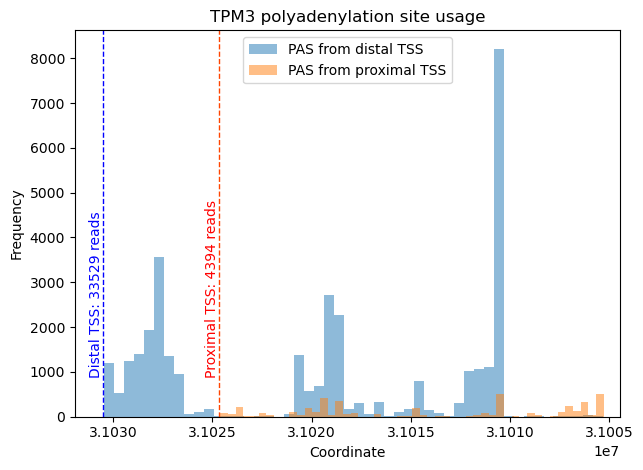

In [4]:
# restrict to the annotated gene interval omitting a few ultra-distal 'PAS' 
plot_df = boundary_df.filter((pl.col("pas") > 31004465) & (pl.col("pas") < 31031932))

for category in ["distal_tss","internal_tss"]:
    subset = plot_df.filter(pl.col("tss_category") == category)
    values = subset["pas"].to_list()
    plt.hist(values, bins=50, alpha=0.5, label=category)

plt.xlabel("Coordinate")
plt.ylabel("Frequency")
plt.title("TPM3 polyadenylation site usage")
plt.xlim(31004465, 31031932)
plt.tight_layout()
plt.axvline( (31024712+31024640) / 2, color = "#FF4500", linewidth = 1, linestyle='--') 
plt.axvline( (31030443+31030578) / 2, color = "blue", linewidth = 1, linestyle='--')
plt.gca().invert_xaxis()  # Flip the X-axis
plt.legend(labels = ["PAS from distal TSS","PAS from proximal TSS"])

plt.text((31024712+31024640) / 2, plt.ylim()[1]*0.1, 'Proximal TSS: 4394 reads', color='red', 
         rotation=90, verticalalignment='bottom', horizontalalignment='right')
plt.text((31030443+31030578) / 2, plt.ylim()[1]*0.1, 'Distal TSS: 33529 reads', color='blue',
         rotation=90, verticalalignment='bottom', horizontalalignment='right')

#plt.axvline((31010651+31010663)/2,color="gray",linestyle="-")
#plt.axvline((31005300+31005322)/2,color="gray",linestyle="-")
#plt.axvline(31010875,color="gray",linestyle="-")
#plt.axvline((31019275+31019324)/2,color="gray",linestyle="-")
#plt.axvline((31011369+ 31011381)/2,color="gray",linestyle="-")
#plt.axvline((31027822 +31027868)/2,color="gray",linestyle="-")

plt.show()

In [5]:
# mydgf is approximately +strand chr1:25,007,734-25,018,000
# collect alignment intervals and subset to the TSS defined by paraclu:
mydgf_starts = []
mydgf_stops = []

for read in mybam.fetch():
    if not read.is_reverse:
        continue
    mydgf_starts.append(read.reference_start)
    mydgf_stops.append(read.reference_end)

mydgf_df = pl.DataFrame({
    "tss": mydgf_starts,
    "pas": mydgf_stops
}).with_columns([
    (
        pl.when((pl.col("tss") >= 25007857) & (pl.col("tss") <= 25007970)).then(pl.lit("distal_tss"))
        # coordinates of strongest TSS peak ^^
        .otherwise(pl.lit("other")).alias("tss_category")
    )])



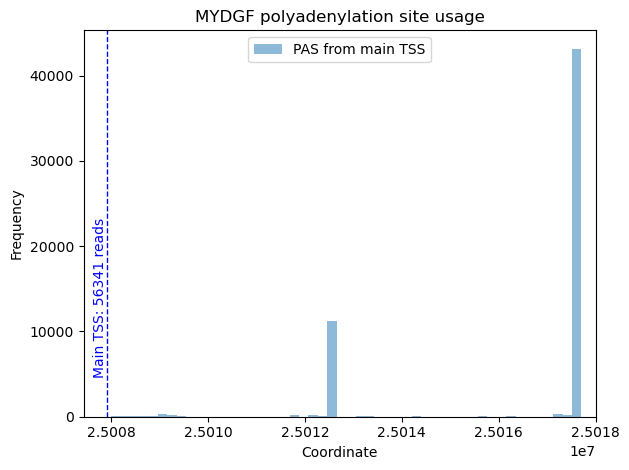

In [6]:
plot2_df = mydgf_df.filter(pl.col('pas') < 25018000, pl.col('tss_category')=="distal_tss")
values = plot2_df["pas"].to_list()
plt.hist(values, bins=50, alpha=0.5,label="PAS from main TSS")
plt.xlabel("Coordinate")
plt.ylabel("Frequency")
plt.title("MYDGF polyadenylation site usage")
plt.xlim(25007434, 25018000)
plt.tight_layout()
plt.axvline( (25007857+25007970) / 2, color = "blue", linewidth = 1, linestyle='--') 
plt.text((25007857+25007970) / 2, plt.ylim()[1]*0.1, 'Main TSS: 56341 reads', color='blue',
         rotation=90, verticalalignment='bottom', horizontalalignment='right')
plt.legend()
plt.show()

In [7]:
# let's look at srrm2 but parse the peaks automatically


gtf =  pd.read_csv("/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf", sep="\t", comment="#", header=None,
                  names=["Chromosome", "Source", "Feature", "Start", "End",
                         "Score", "Strand", "Frame", "Attributes"])

gtf['gene_id'] = gtf['Attributes'].str.extract(r'gene_id "([^"]+)"')

genes_df = gtf[gtf.Feature == "gene"].copy()
genes = pr.PyRanges(genes_df[["Chromosome", "Start", "End", "Strand", "Attributes"]])
peaks = pr.read_bed("/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

overlaps = peaks.join(genes, strandedness="same").df

In [8]:
overlaps['gene_id'] = overlaps['Attributes'].str.extract(r'gene_id "([^"]+)"')
overlaps[overlaps['gene_id'] == "BLAG01102829"]

,Chromosome,Start,End,Name,Score,Strand,Start_b,End_b,Strand_b,Attributes,gene_id
1050,chr1,27944963,27945078,tss_2369,2369,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829
1051,chr1,27978620,27978686,tss_1389,1389,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829
1052,chr1,27997396,27997483,tss_1267,1267,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829
1053,chr1,28029256,28029325,tss_3608,3608,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829
1445,chr1,27912048,27912076,pas_2454,2454,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829
1446,chr1,27925417,27925449,pas_520,520,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829
1447,chr1,27926277,27926292,pas_990,990,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829
1448,chr1,27930101,27930150,pas_1341,1341,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829
1449,chr1,27972030,27972099,pas_2427,2427,-,27912049,28029322,-,"gene_id ""BLAG01102829""; gene_name ""SRRM2"";",BLAG01102829


In [21]:
# what fraction of tss reads end in a pas peak?
# how much entropy in the reads from each tss peak?
def plot_tss_targets(gene_id,bampath,gtfpath,peakspath,celltype):
    # e.g. "BLAG01102829"

    bamf = ps.AlignmentFile(bampath,"rb")
    gtf =  pd.read_csv(gtfpath, sep="\t", comment="#", header=None,
                  names=["Chromosome", "Source", "Feature", "Start", "End",
                         "Score", "Strand", "Frame", "Attributes"])
    gtf['gene_id'] = gtf['Attributes'].str.extract(r'gene_id "([^"]+)"')
    genes_df = gtf[gtf.Feature == "gene"].copy()
    genes = pr.PyRanges(genes_df[["Chromosome", "Start", "End", "Strand", "Attributes"]])
    peaks = pr.read_bed(peakspath)
    overlaps = peaks.join(genes, strandedness="same").df

    gene_loc = genes_df[genes_df['gene_id']==gene_id]
    gene_strand = gene_loc['Strand'].iloc[0]

    tss_coords = []
    pas_coords = []
    for read in bamf.fetch(gene_loc['Chromosome'].iloc[0],gene_loc['Start'].iloc[0]-1000,gene_loc['End'].iloc[0]+1000):
        try:
            read_celltype = read.get_tag("CL")
            if read_celtype != celltype:
                pass
        except:
            pass
            
        if(gene_strand == "+"):
            if not read.is_reverse:
                continue
            tss_coords.append(read.reference_start)
            pas_coords.append(read.reference_end)
        else: # gene is minus strand
            # only keep positive strand reads
            if read.is_reverse:
                continue
            tss_coords.append(read.reference_end)
            pas_coords.append(read.reference_start)
    tss_df = pd.DataFrame({
    "Chromosome": gene_loc['Chromosome'].iloc[0],
    "Start": tss_coords,
    "End":None,
    "Strand": gene_strand,
    "PAS": pas_coords
    })
    tss_df['End']=tss_df['Start']+1
    # add the corresonding tss peak if it overlaps the tss in srrm2_df
    tss_df = pl.from_pandas(pr.PyRanges(tss_df).join(peaks,strandedness="same").df)

    # take top n TSS peaks:
    # total TSS = sum(Score of unique TSS peaks)
    major_peaks = tss_df.select(['Name', 'Score']).unique()
    major_peaks = major_peaks.filter((pl.col('Name').str.starts_with('tss_')) & (pl.col('Score') > 1000))
    
    # keep tss with 5% of total
    tot_tss = major_peaks.select(pl.col("Score").sum()).item()
    major_peaks = major_peaks.filter(
        pl.col('Score') > 0.05 * tot_tss
    )
    major_peaks = major_peaks.sort("Score",descending=True).get_column('Name').to_list()

    if(gene_strand == "+"):
        tss_df = tss_df.filter(pl.col("PAS") <= gene_loc['End'].iloc[0]+1000)
    else:
        tss_df = tss_df.filter(pl.col("PAS") >= gene_loc['Start'].iloc[0]-1000)
                      
    # p lotting part
    # need to filter by the gene intervals to excluve PAS that are in timbuktu
    for peak in major_peaks:
        subset = tss_df.filter(pl.col("Name") == peak)
        peak_start = subset.get_column('Start_b').unique().item()
        peak_end = subset.get_column('End_b').unique().item()
        values = subset["PAS"].to_list()
        bins = np.linspace(gene_loc['Start'].iloc[0]-1000, gene_loc['End'].iloc[0]+1000, 100 + 1)
        n, bins, patches = plt.hist(values, bins=bins, alpha=0.5, label=peak,edgecolor='gray')
        color = patches[0].get_facecolor()
        plt.axvline( (peak_start+peak_end) / 2, linewidth = 1, linestyle='--', color=color) 

    plt.xlabel("Coordinate")
    plt.ylabel("Frequency")
    plt.title(gene_id + " polyadenylation site usage from major TSS(s)")
    plt.tight_layout()
    plt.xlim(gene_loc['Start'].iloc[0]-1000,gene_loc['End'].iloc[0]+1000)
    plt.legend()
    bamf.close()
    return(tss_df)




In [15]:
gene_id = "BLAG01001673"
bampath="/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.shortread_ann.bam"
gtfpath="/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf"
peakspath="/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed"
bamf = ps.AlignmentFile(bampath,"rb")
gtf =  pd.read_csv(gtfpath, sep="\t", comment="#", header=None,
                  names=["Chromosome", "Source", "Feature", "Start", "End",
                         "Score", "Strand", "Frame", "Attributes"])
gtf['gene_id'] = gtf['Attributes'].str.extract(r'gene_id "([^"]+)"')
genes_df = gtf[gtf.Feature == "gene"].copy()
genes = pr.PyRanges(genes_df[["Chromosome", "Start", "End", "Strand", "Attributes"]])
peaks = pr.read_bed(peakspath)
overlaps = peaks.join(genes, strandedness="same").df

gene_loc = genes_df[genes_df['gene_id']==gene_id]
gene_strand = gene_loc['Strand'].iloc[0]

tss_coords = []
pas_coords = []

In [11]:
for read in bamf.fetch(gene_loc['Chromosome'].iloc[0],gene_loc['Start'].iloc[0]-200,gene_loc['End'].iloc[0]+200):
    if(gene_strand == "+"):
        if not read.is_reverse:
            continue
        tss_coords.append(read.reference_start)
        pas_coords.append(read.reference_end)
    else: # gene is minus strand
        # only keep positive strand reads
        if read.is_reverse:
            continue
        tss_coords.append(read.reference_end)
        pas_coords.append(read.reference_start)
pas_df = pd.DataFrame({
"Chromosome": gene_loc['Chromosome'].iloc[0],
"Start": pas_coords,
"End":None,
"Strand": gene_strand,
"TSS": tss_coords
})

In [12]:
pas_df['End']=pas_df['Start']+1
    # add the corresonding tss peak if it overlaps the tss in srrm2_df
pas_df = pl.from_pandas(pr.PyRanges(pas_df).join(peaks,strandedness="same").df)
    # exclude the reads where the TSS is in timbuktu:
if(gene_strand == "+"):
    pas_df = pas_df.filter(pl.col("TSS") > gene_loc['Start'].iloc[0]-100)
else:
    pas_df = pas_df.filter(pl.col("TSS") < gene_loc['End'].iloc[0]+100)

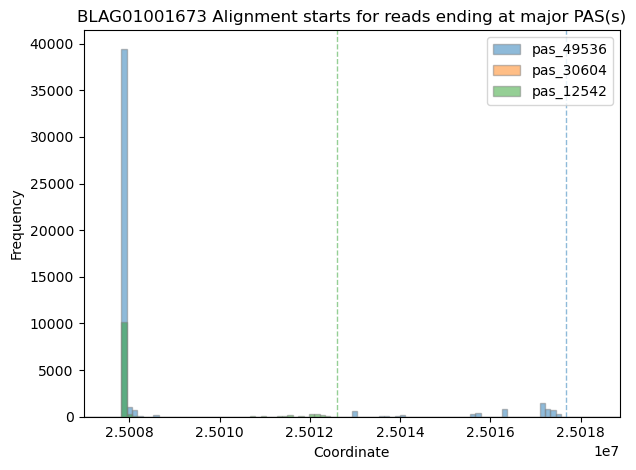

In [13]:
major_peaks = pas_df.select(['Name', 'Score']).unique()
major_peaks = major_peaks.filter((pl.col('Name').str.starts_with('pas_')) & (pl.col('Score') > 1000))
tot_pas = major_peaks.select(pl.col("Score").sum()).item()
major_peaks = major_peaks.filter(
        pl.col('Score') > 0.05 * tot_pas
    )
major_peaks = major_peaks.sort("Score",descending=True).get_column('Name').to_list()
major_peaks
for peak in major_peaks:
    subset = pas_df.filter(pl.col("Name") == peak)
    peak_start = subset.get_column('Start_b').unique().item()
    peak_end = subset.get_column('End_b').unique().item()
    values = subset["TSS"].to_list()
    bins = np.linspace(gene_loc['Start'].iloc[0]-1000, gene_loc['End'].iloc[0]+1000, 100 + 1)
    n, bins, patches = plt.hist(values, bins=bins, alpha=0.5, label=peak,edgecolor='gray')
    color = patches[0].get_facecolor()
    plt.axvline( (peak_start+peak_end) / 2, linewidth = 1, linestyle='--', color=color) 

plt.xlabel("Coordinate")
plt.ylabel("Frequency")
plt.title(gene_id + " Alignment starts for reads ending at major PAS(s)")
plt.tight_layout()
plt.xlim(gene_loc['Start'].iloc[0]-1000,gene_loc['End'].iloc[0]+1000)
plt.legend()
bamf.close()

In [30]:

###############
def plot_pas_origins(gene_id,bampath,gtfpath,peakspath):
    # e.g. "BLAG01102829"
        
    bamf = ps.AlignmentFile(bampath,"rb") # bambu bam alignments
    gtf =  pd.read_csv(gtfpath, sep="\t", comment="#", header=None,
                  names=["Chromosome", "Source", "Feature", "Start", "End",
                         "Score", "Strand", "Frame", "Attributes"])
    gtf['gene_id'] = gtf['Attributes'].str.extract(r'gene_id "([^"]+)"')
    genes_df = gtf[gtf.Feature == "gene"].copy()
    genes = pr.PyRanges(genes_df[["Chromosome", "Start", "End", "Strand", "Attributes"]])
    peaks = pr.read_bed(peakspath)
    overlaps = peaks.join(genes, strandedness="same").df

    gene_loc = genes_df[genes_df['gene_id']==gene_id]
    gene_strand = gene_loc['Strand'].iloc[0]

    tss_coords = []
    pas_coords = []
    for read in bamf.fetch(gene_loc['Chromosome'].iloc[0],gene_loc['Start'].iloc[0]-200,gene_loc['End'].iloc[0]+200):
        if(gene_strand == "+"):
            if not read.is_reverse:
                continue
            tss_coords.append(read.reference_start)
            pas_coords.append(read.reference_end)
        else: # gene is minus strand
            # only keep positive strand reads
            if read.is_reverse:
                continue
            tss_coords.append(read.reference_end)
            pas_coords.append(read.reference_start)
    pas_df = pd.DataFrame({
    "Chromosome": gene_loc['Chromosome'].iloc[0],
    "Start": pas_coords,
    "End":None,
    "Strand": gene_strand,
    "TSS": tss_coords
    })
    pas_df['End']=pas_df['Start']+1
    # add the corresonding tss peak if it overlaps the tss in srrm2_df
    pas_df = pl.from_pandas(pr.PyRanges(pas_df).join(peaks,strandedness="same").df)
    # exclude the reads where the TSS is in timbuktu:
    # or the PAS is in timbuktu:
    if(gene_strand == "+"):
        pas_df = pas_df.filter(pl.col("TSS") >= gene_loc['Start'].iloc[0]-1000)
        pas_df = pas_df.filter(pl.col("Start") <= gene_loc['End'].iloc[0]+1000) # start is pas
    else:
        pas_df = pas_df.filter(pl.col("TSS") <= gene_loc['End'].iloc[0]+1000)
        pas_df = pas_df.filter(pl.col("Start") >= gene_loc['Start'].iloc[0]-1000)
    # take top n PAS peaks:
    # total PAS = sum(Score of unique PAS peaks)
    major_peaks = pas_df.select(['Name', 'Score']).unique()
    major_peaks = major_peaks.filter((pl.col('Name').str.starts_with('pas_')) & (pl.col('Score') > 1000))
    
    # keep tss with 5% of total
    tot_pas = major_peaks.select(pl.col("Score").sum()).item()
    major_peaks = major_peaks.filter(
        pl.col('Score') > 0.05 * tot_pas
    )
    major_peaks = major_peaks.sort("Score",descending=True).get_column('Name').to_list()
    
    print(major_peaks)                  
    # p lotting part
    # need to filter by the gene intervals to excluve PAS that are in timbuktu
    for peak in major_peaks:
        subset = pas_df.filter(pl.col("Name") == peak)
        peak_start = subset.get_column('Start_b').unique().item()
        peak_end = subset.get_column('End_b').unique().item()
        values = subset["TSS"].to_list()
        bins = np.linspace(gene_loc['Start'].iloc[0]-1000, gene_loc['End'].iloc[0]+1000, 100 + 1)
        n, bins, patches = plt.hist(values, bins=bins, alpha=0.5, label=peak,edgecolor='gray')
        color = patches[0].get_facecolor()
        plt.axvline( (peak_start+peak_end) / 2, linewidth = 1, linestyle='--', color=color) 

    plt.xlabel("Coordinate")
    plt.ylabel("Frequency")
    plt.title(gene_id + " Alignment starts for reads ending at major PAS(s)")
    plt.tight_layout()
    plt.xlim(gene_loc['Start'].iloc[0]-1000,gene_loc['End'].iloc[0]+1000)
    plt.legend()
    bamf.close()
    return(pas_df)

############3
#########33bb

['pas_49536', 'pas_12542']


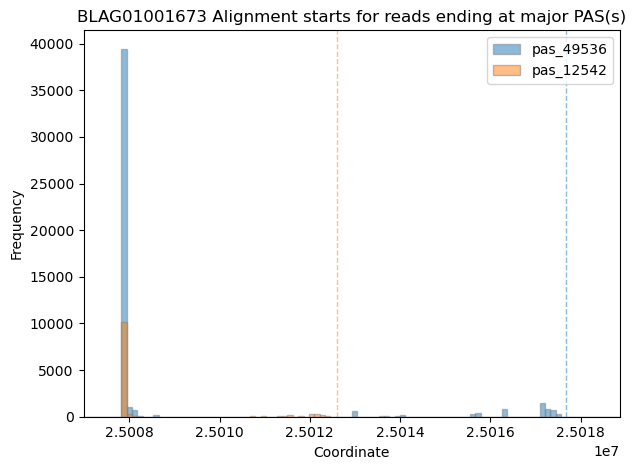

In [15]:
mydgf_pas_out = plot_pas_origins("BLAG01001673","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

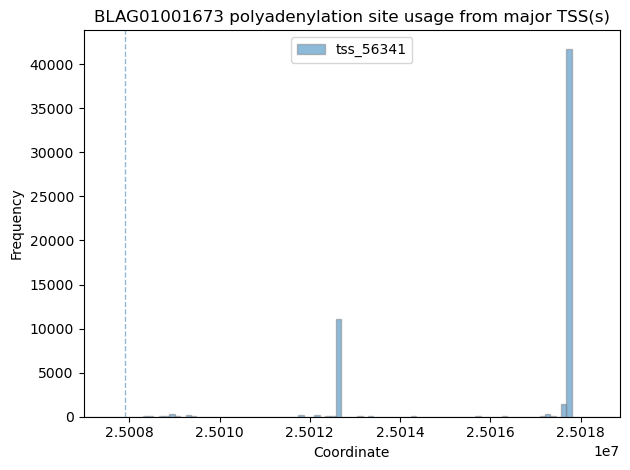

In [16]:
mydgf_tss_out = plot_tss_targets("BLAG01001673","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

In [17]:
peaks.df[peaks.df["Name"]=="pas_30604"]

,Chromosome,Start,End,Name,Score,Strand
840,chr1,25212064,25212101,pas_30604,30604,+


['pas_2454', 'pas_2427', 'pas_1341']


Chromosome,Start,End,Strand,TSS,Start_b,End_b,Name,Score,Strand_b
cat,i64,i64,cat,i64,i64,i64,str,i64,cat
"""chr1""",27912048,27912049,"""-""",27912623,27912048,27912076,"""pas_2454""",2454,"""-"""
"""chr1""",27912048,27912049,"""-""",27912803,27912048,27912076,"""pas_2454""",2454,"""-"""
"""chr1""",27912048,27912049,"""-""",27913221,27912048,27912076,"""pas_2454""",2454,"""-"""
"""chr1""",27912048,27912049,"""-""",27912955,27912048,27912076,"""pas_2454""",2454,"""-"""
"""chr1""",27912048,27912049,"""-""",27912955,27912048,27912076,"""pas_2454""",2454,"""-"""
…,…,…,…,…,…,…,…,…,…
"""chr1""",27972097,27972098,"""-""",27972503,27972030,27972099,"""pas_2427""",2427,"""-"""
"""chr1""",27972097,27972098,"""-""",27978655,27972030,27972099,"""pas_2427""",2427,"""-"""
"""chr1""",27972097,27972098,"""-""",27978674,27972030,27972099,"""pas_2427""",2427,"""-"""


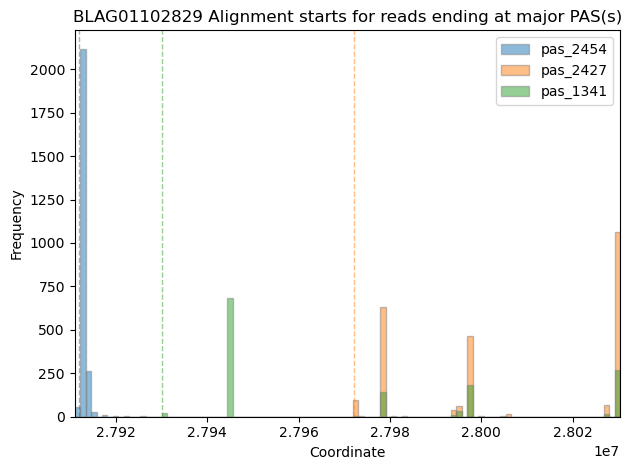

In [18]:
plot_pas_origins("BLAG01102829","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")



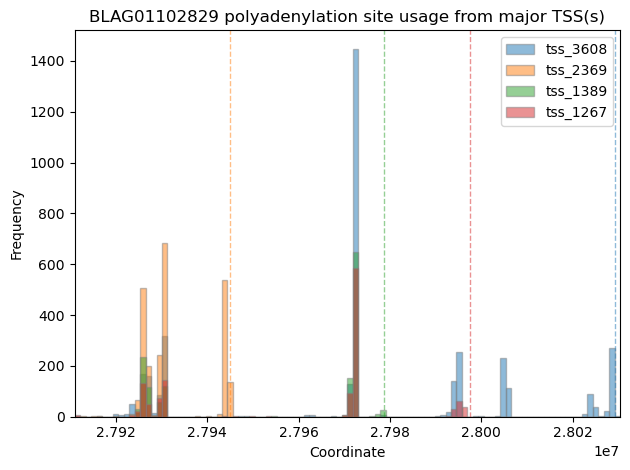

In [19]:
my_tss_df = plot_tss_targets("BLAG01102829","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")



Chromosome,Start,End,Strand,PAS,Start_b,End_b,Name,Score,Strand_b
cat,i64,i64,cat,i64,i64,i64,str,i64,cat
"""chr1""",25007857,25007858,"""+""",25017688,25007857,25007970,"""tss_56341""",56341,"""+"""
"""chr1""",25007857,25007858,"""+""",25017688,25007857,25007970,"""tss_56341""",56341,"""+"""
"""chr1""",25007857,25007858,"""+""",25017688,25007857,25007970,"""tss_56341""",56341,"""+"""
"""chr1""",25007857,25007858,"""+""",25012597,25007857,25007970,"""tss_56341""",56341,"""+"""
"""chr1""",25007857,25007858,"""+""",25017688,25007857,25007970,"""tss_56341""",56341,"""+"""
…,…,…,…,…,…,…,…,…,…
"""chr1""",25017219,25017220,"""+""",25017687,25017098,25017220,"""tss_1625""",1625,"""+"""
"""chr1""",25017219,25017220,"""+""",25017696,25017098,25017220,"""tss_1625""",1625,"""+"""
"""chr1""",25017219,25017220,"""+""",25017685,25017098,25017220,"""tss_1625""",1625,"""+"""


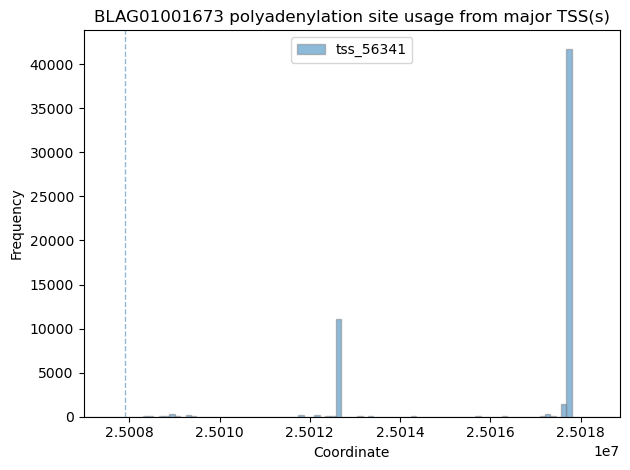

In [20]:
plot_tss_targets("BLAG01001673","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

['pas_49536', 'pas_12542']


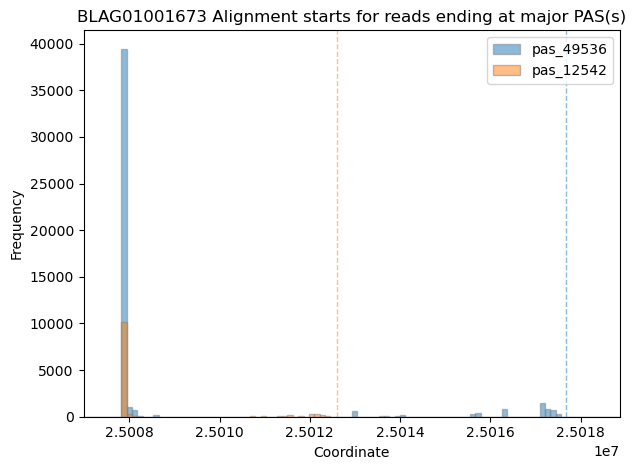

In [21]:
mydgf_pas_out = plot_pas_origins("BLAG01001673","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

In [22]:
mydgf_pas_out.select(["Chromosome","Start_b","End_b","Strand","Name"]).unique().filter(pl.col("Name").str.contains("pas"))

Chromosome,Start_b,End_b,Strand,Name
cat,i64,i64,cat,str
"""chr1""",25012583,25012603,"""+""","""pas_12542"""
"""chr1""",25017665,25017701,"""+""","""pas_49536"""


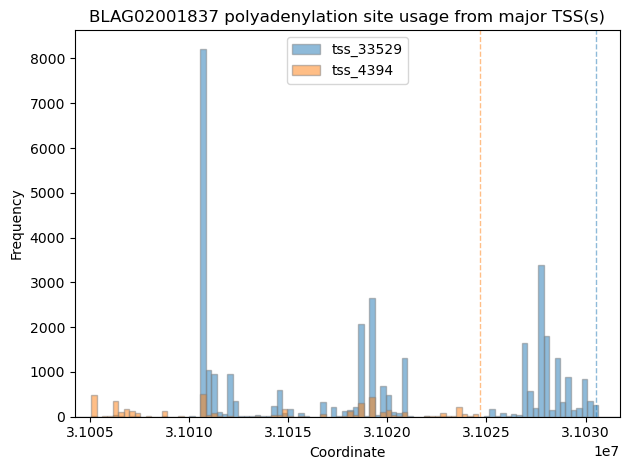

In [25]:
#Counter({'Somites_muscular': 1611,
#         'Differentiated_Neurons': 869,
#         'Epithelial_ectoderm': 514,
#         'Neural_precursor': 433,
#         'Pharyngeal_mesoderm': 415,
#         'Hindgut': 402,
#         'Foregut': 359,
#         'Gut_related': 203,
#         'NotClear1': 191,
#         'Midgut': 152})

aaa=plot_tss_targets("BLAG02001837","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.shortread_ann.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed",
                "Somites_muscular")

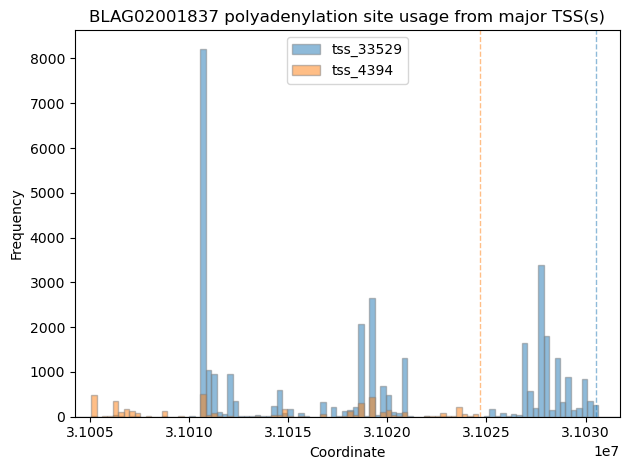

In [24]:
nnn=plot_tss_targets("BLAG02001837","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.shortread_ann.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed",
                "Differentiated_Neurons")

['pas_68322', 'pas_5109']


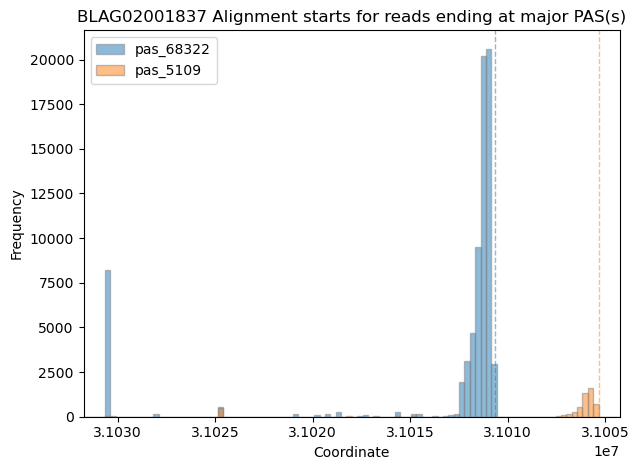

In [24]:
plot_pas_origins("BLAG02001837","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

plt.gca().invert_xaxis()  # Flip the X-axis


['pas_3683', 'pas_1914']


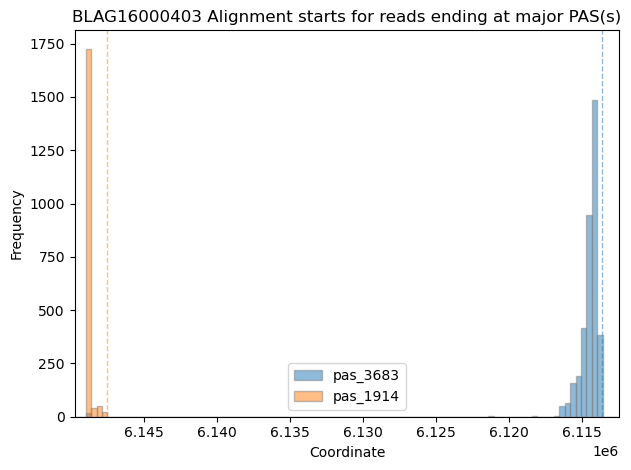

In [25]:
plot_pas_origins("BLAG16000403","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")
plt.gca().invert_xaxis()  # Flip the X-axis


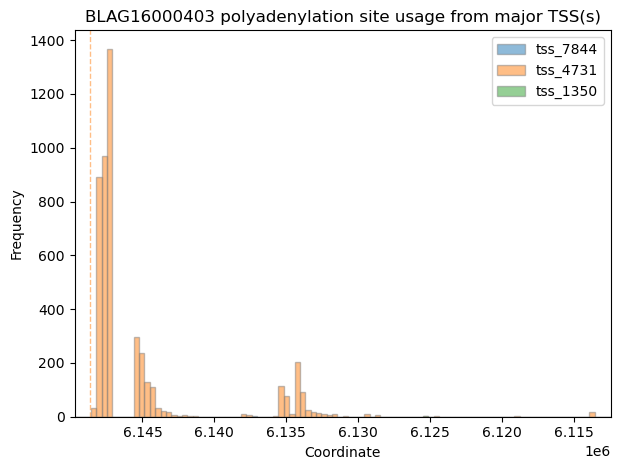

In [27]:
plot_tss_targets("BLAG16000403","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")
plt.gca().invert_xaxis()  # Flip the X-axis


Chromosome,Start,End,Strand,PAS,Start_b,End_b,Name,Score,Strand_b
cat,i64,i64,cat,i64,i64,i64,str,i64,cat
"""chr8""",10093645,10093646,"""+""",10121968,10093621,10093699,"""tss_1741""",1741,"""+"""
"""chr8""",10093645,10093646,"""+""",10121968,10093621,10093699,"""tss_1741""",1741,"""+"""
"""chr8""",10093645,10093646,"""+""",10121968,10093621,10093699,"""tss_1741""",1741,"""+"""
"""chr8""",10093663,10093664,"""+""",10121968,10093621,10093699,"""tss_1741""",1741,"""+"""
"""chr8""",10093663,10093664,"""+""",10121968,10093621,10093699,"""tss_1741""",1741,"""+"""
…,…,…,…,…,…,…,…,…,…
"""chr8""",10117533,10117534,"""+""",10121481,10117469,10117535,"""tss_7551""",7551,"""+"""
"""chr8""",10117533,10117534,"""+""",10121477,10117469,10117535,"""tss_7551""",7551,"""+"""
"""chr8""",10117533,10117534,"""+""",10121481,10117469,10117535,"""tss_7551""",7551,"""+"""


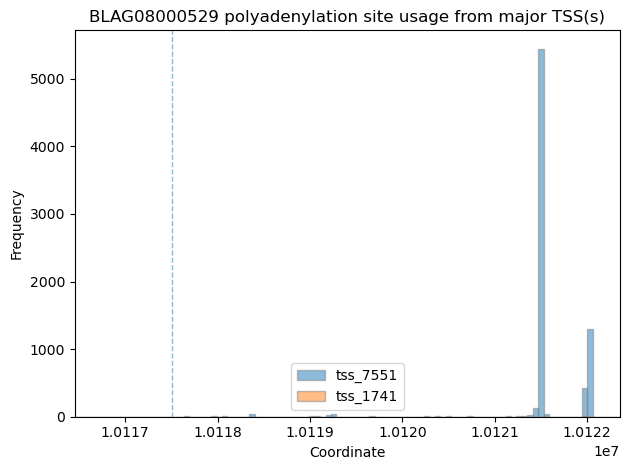

In [33]:
plot_tss_targets("BLAG08000529","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

['pas_6813', 'pas_2097']


Chromosome,Start,End,Strand,TSS,Start_b,End_b,Name,Score,Strand_b
cat,i64,i64,cat,i64,i64,i64,str,i64,cat
"""chr8""",10121469,10121470,"""+""",10117145,10121468,10121487,"""pas_6813""",6813,"""+"""
"""chr8""",10121469,10121470,"""+""",10117145,10121468,10121487,"""pas_6813""",6813,"""+"""
"""chr8""",10121998,10121999,"""+""",10117314,10121997,10122004,"""pas_2097""",2097,"""+"""
"""chr8""",10121998,10121999,"""+""",10117314,10121997,10122004,"""pas_2097""",2097,"""+"""
"""chr8""",10121998,10121999,"""+""",10117314,10121997,10122004,"""pas_2097""",2097,"""+"""
…,…,…,…,…,…,…,…,…,…
"""chr8""",10122001,10122002,"""+""",10121376,10121997,10122004,"""pas_2097""",2097,"""+"""
"""chr8""",10122001,10122002,"""+""",10121428,10121997,10122004,"""pas_2097""",2097,"""+"""
"""chr8""",10122001,10122002,"""+""",10121428,10121997,10122004,"""pas_2097""",2097,"""+"""


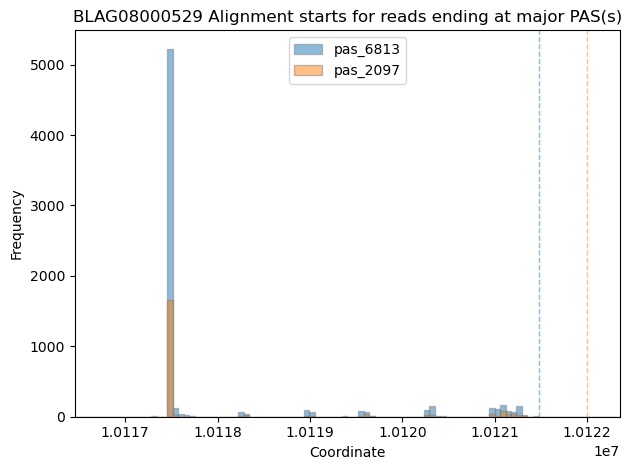

In [32]:
plot_pas_origins("BLAG08000529","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

['pas_5342', 'pas_4545', 'pas_2400']


Chromosome,Start,End,Strand,TSS,Start_b,End_b,Name,Score,Strand_b
cat,i64,i64,cat,i64,i64,i64,str,i64,cat
"""chr8""",9878618,9878619,"""+""",9877911,9878610,9878788,"""tss_892""",892,"""+"""
"""chr8""",9878618,9878619,"""+""",9877911,9878610,9878788,"""tss_892""",892,"""+"""
"""chr8""",9878618,9878619,"""+""",9877911,9878610,9878788,"""tss_892""",892,"""+"""
"""chr8""",9887779,9887780,"""+""",9878433,9887708,9887784,"""pas_2400""",2400,"""+"""
"""chr8""",9887712,9887713,"""+""",9878436,9887708,9887784,"""pas_2400""",2400,"""+"""
…,…,…,…,…,…,…,…,…,…
"""chr8""",9933094,9933095,"""+""",9932975,9933087,9933097,"""pas_4545""",4545,"""+"""
"""chr8""",9933092,9933093,"""+""",9932981,9933087,9933097,"""pas_4545""",4545,"""+"""
"""chr8""",9933094,9933095,"""+""",9932987,9933087,9933097,"""pas_4545""",4545,"""+"""


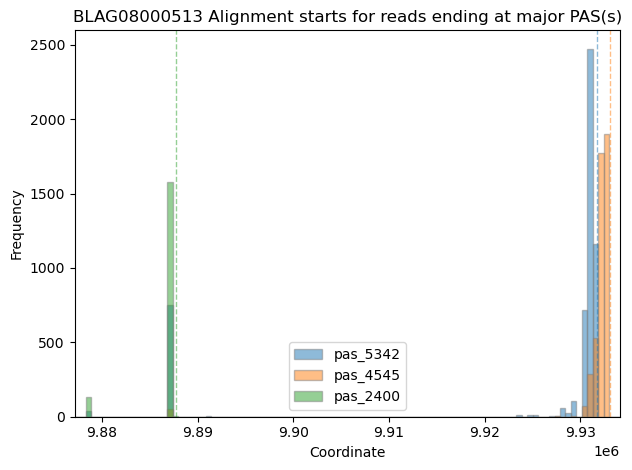

In [34]:
plot_pas_origins("BLAG08000513","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

Chromosome,Start,End,Strand,PAS,Start_b,End_b,Name,Score,Strand_b
cat,i64,i64,cat,i64,i64,i64,str,i64,cat
"""chr8""",9878610,9878611,"""+""",9888410,9878610,9878788,"""tss_892""",892,"""+"""
"""chr8""",9878610,9878611,"""+""",9888410,9878610,9878788,"""tss_892""",892,"""+"""
"""chr8""",9878610,9878611,"""+""",9888410,9878610,9878788,"""tss_892""",892,"""+"""
"""chr8""",9878610,9878611,"""+""",9931785,9878610,9878788,"""tss_892""",892,"""+"""
"""chr8""",9878610,9878611,"""+""",9888410,9878610,9878788,"""tss_892""",892,"""+"""
…,…,…,…,…,…,…,…,…,…
"""chr8""",9931780,9931781,"""+""",9933093,9931766,9931787,"""pas_5342""",5342,"""+"""
"""chr8""",9931785,9931786,"""+""",9933094,9931766,9931787,"""pas_5342""",5342,"""+"""
"""chr8""",9931785,9931786,"""+""",9932537,9931766,9931787,"""pas_5342""",5342,"""+"""


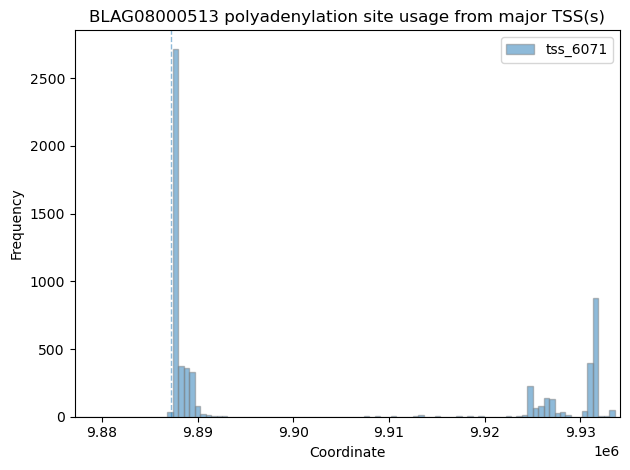

In [35]:
plot_tss_targets("BLAG08000513","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

ValueError: can only call '.item()' if the Series is of length 1, or an explicit index is provided (Series is of length 0)

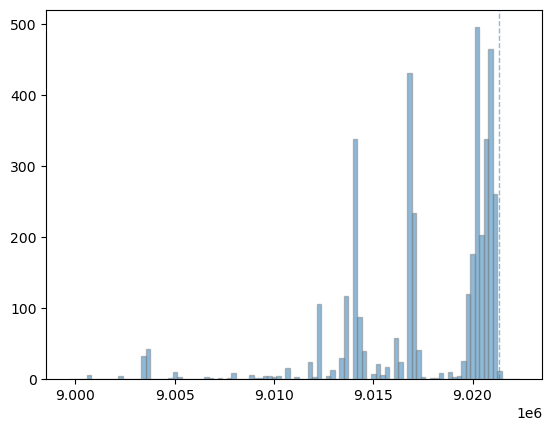

In [36]:
fubp1_tss = plot_tss_targets("BLAG08000445","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

['pas_4765']


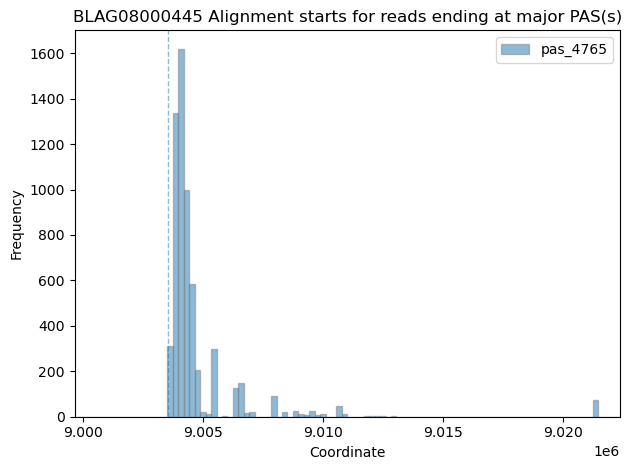

In [37]:
fubp1_pas = plot_pas_origins("BLAG08000445","/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/Bambu.demultiplexed.bam",
                 "/users/mirimia/jchamberlin/scratch/refs/gtf/Bla_annot_fake_completed.sorted.gtf",
                 "/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/paraclu/peaks.filt.cat.bed")

In [14]:
gene_loc = genes_df[genes_df['gene_id']=="BLAG02001837"]
gene_loc.Start.iloc[0]

31005237

In [17]:
# do TPM3 split by cell type
# do TPM3 with exons evaluated too
ct = []
for read in bamf.fetch("chr2",gene_loc.Start.iloc[0], gene_loc.End.iloc[0]):
    try: ct.append(read.get_tag("CL"))
    except:
        pass
        

In [20]:
from collections import Counter
Counter(ct)

Counter({'Somites_muscular': 1611,
         'Differentiated_Neurons': 869,
         'Epithelial_ectoderm': 514,
         'Neural_precursor': 433,
         'Pharyngeal_mesoderm': 415,
         'Hindgut': 402,
         'Foregut': 359,
         'Gut_related': 203,
         'NotClear1': 191,
         'Midgut': 152})